<a href="https://colab.research.google.com/github/kkkissiedu/Concrete-Surface-Crack-Detection-Model/blob/main/concrete_surface_crack_detection_model_tf_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Machine Learning Models/Concrete Surface Crack Detection Model

Mounted at /content/drive
/content/drive/My Drive/Machine Learning Models/Concrete Surface Crack Detection Model


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

# Directories to Images

In [ ]:
# Destination PARENT directory on the Colab VM.
COLAB_DESTINATION_PARENT_DIR = '/content/Concrete Surface Crack Detection Model/Dataset'

print(f"Creating destination directory (if it doesn't exist): {COLAB_DESTINATION_PARENT_DIR}")
!mkdir -p "{COLAB_DESTINATION_PARENT_DIR}"
print("Destination directory check/creation complete.")

# --- Step 2: Copy the directory recursively (your existing cp command) ---
DRIVE_DATA_DIR_PATH = '/content/drive/MyDrive/Machine Learning Models/Concrete Surface Crack Detection Model/Data' # Your source
print(f"Copying directory {DRIVE_DATA_DIR_PATH} to {COLAB_DESTINATION_PARENT_DIR}...")
!cp -r "{DRIVE_DATA_DIR_PATH}" "{COLAB_DESTINATION_PARENT_DIR}"
print("Directory copy complete.")

Creating destination directory (if it doesn't exist): /content/Concrete Surface Crack Detection Model/Dataset
Destination directory check/creation complete.
Copying directory /content/drive/MyDrive/Machine Learning Models/Concrete Surface Crack Detection Model/Data to /content/Concrete Surface Crack Detection Model/Dataset...
Directory copy complete.


In [ ]:
positive_dir = Path('/content/Concrete Surface Crack Detection Model/Dataset/Data/Positive')
negative_dir = Path('/content/Concrete Surface Crack Detection Model/Dataset/Data/Negative')

In [ ]:
print(f"Positive directory exists: {positive_dir.exists()}")
print(f"Is it a directory: {positive_dir.is_dir()}")

print(f"Negative directory exists: {negative_dir.exists()}")
print(f"Is it a directory: {negative_dir.is_dir()}")

Positive directory exists: True
Is it a directory: True
Negative directory exists: True
Is it a directory: True


# Creating DataFrames

In [ ]:
list(positive_dir.glob(r'*.jpg'))

[PosixPath('/content/Concrete Surface Crack Detection Model/Dataset/Data/Positive/05718.jpg'),
 PosixPath('/content/Concrete Surface Crack Detection Model/Dataset/Data/Positive/18248_1.jpg'),
 PosixPath('/content/Concrete Surface Crack Detection Model/Dataset/Data/Positive/07457.jpg'),
 PosixPath('/content/Concrete Surface Crack Detection Model/Dataset/Data/Positive/02831.jpg'),
 PosixPath('/content/Concrete Surface Crack Detection Model/Dataset/Data/Positive/09506.jpg'),
 PosixPath('/content/Concrete Surface Crack Detection Model/Dataset/Data/Positive/08296.jpg'),
 PosixPath('/content/Concrete Surface Crack Detection Model/Dataset/Data/Positive/17220_1.jpg'),
 PosixPath('/content/Concrete Surface Crack Detection Model/Dataset/Data/Positive/06751.jpg'),
 PosixPath('/content/Concrete Surface Crack Detection Model/Dataset/Data/Positive/05933.jpg'),
 PosixPath('/content/Concrete Surface Crack Detection Model/Dataset/Data/Positive/13637_1.jpg'),
 PosixPath('/content/Concrete Surface Crack 

# Dataframe Function

In [ ]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name = 'Filepath').astype(str)
    labels = pd.Series(label, name = 'label', index = filepaths.index)

    #Combining filepaths and labels dataframes
    df = pd.concat([filepaths, labels], axis = 1)
    return df

In [ ]:
positive_df = generate_df(positive_dir, label = 'POSITIVE')
negative_df =  generate_df(negative_dir, label = 'NEGATIVE')

#Create a dataframe that is a combination of both positive and negative dataframes
all_df = pd.concat([positive_df, negative_df], axis = 0).sample(frac = 1.0, random_state = 1).reset_index(drop = True)
all_df

,Filepath,label
0,/content/Concrete Surface Crack Detection Mode...,POSITIVE
1,/content/Concrete Surface Crack Detection Mode...,POSITIVE
2,/content/Concrete Surface Crack Detection Mode...,POSITIVE
3,/content/Concrete Surface Crack Detection Mode...,NEGATIVE
4,/content/Concrete Surface Crack Detection Mode...,POSITIVE
...,...,...
39995,/content/Concrete Surface Crack Detection Mode...,POSITIVE
39996,/content/Concrete Surface Crack Detection Mode...,NEGATIVE
39997,/content/Concrete Surface Crack Detection Mode...,POSITIVE
39998,/content/Concrete Surface Crack Detection Mode...,POSITIVE


# Splitting data into Training and Test sets

In [ ]:
train_df, test_df = train_test_split(
    all_df,
    train_size = 0.7,
    shuffle = True,
    random_state = 1
)

# Loading Image Data

In [ ]:

label_map = {'POSITIVE': 1, 'NEGATIVE': 0} # Adjust if your labels are different

if not train_df.empty:
    # Create a true validation set from the original train_df
    # Original train_df (70% of all_df) is split 80% for new_train_df, 20% for val_df_from_train
    train_df_for_tf_dataset, val_df_for_tf_dataset = train_test_split(
        train_df,
        train_size = 0.8,
        shuffle = True,
        random_state = 42
    )

    train_df_for_tf_dataset = train_df_for_tf_dataset.copy()
    val_df_for_tf_dataset = val_df_for_tf_dataset.copy()
    test_df_for_tf_dataset = test_df.copy() # Assuming test_df also needs mapping

    train_df_for_tf_dataset['label_numeric'] = train_df_for_tf_dataset['label'].map(label_map)
    val_df_for_tf_dataset['label_numeric'] = val_df_for_tf_dataset['label'].map(label_map)
    if not test_df_for_tf_dataset.empty:
        test_df_for_tf_dataset['label_numeric'] = test_df_for_tf_dataset['label'].map(label_map)

    print(f"Shape of new training df for tf.data: {train_df_for_tf_dataset.shape}")
    print(f"Shape of new validation df for tf.data: {val_df_for_tf_dataset.shape}")

else:
    print("Original train_df is empty. Training and validation datasets will be empty.")
    # Create empty DataFrames with the necessary column to avoid errors later if you proceed
    train_df_for_tf_dataset = pd.DataFrame(columns=['Filepath', 'label_numeric'])
    val_df_for_tf_dataset = pd.DataFrame(columns=['Filepath', 'label_numeric'])
    # test_df might also be empty if all_df was empty
    if test_df.empty:
        test_df_for_tf_dataset = pd.DataFrame(columns=['Filepath', 'label_numeric'])
    else:
        test_df_for_tf_dataset = test_df.copy()
        test_df_for_tf_dataset['label_numeric'] = test_df_for_tf_dataset['label'].map(label_map)



IMG_HEIGHT = 120
IMG_WIDTH = 120
BATCH_SIZE = 32
CHANNELS = 3

def load_and_preprocess_image(filepath, label):
    # Read the image file
    img = tf.io.read_file(filepath)
    # Decode the image. decode_image tries to infer format.
    # For more control, use tf.image.decode_jpeg or tf.image.decode_png
    img = tf.image.decode_image(img, channels=CHANNELS, expand_animations=False)
    # Resize to the target dimensions
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Ensure the shape is set if decode_image doesn't set it fully
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    # Rescale pixel values from [0, 255] to [0, 1]
    img = img / 255.0
    return img, label


AUTOTUNE = tf.data.AUTOTUNE # For parallel processing optimization

# Training Dataset
if not train_df_for_tf_dataset.empty:
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (train_df_for_tf_dataset['Filepath'].values, train_df_for_tf_dataset['label_numeric'].astype('float32').values)
    )
    train_dataset = train_dataset.shuffle(buffer_size=len(train_df_for_tf_dataset), seed=1, reshuffle_each_iteration=True)
    train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    train_dataset = train_dataset.batch(BATCH_SIZE)
    train_dataset = train_dataset.cache()  # Cache data after first epoch (if it fits in RAM or for faster disk reads)
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) # Crucial for performance
    print(f"Training dataset created successfully. Element spec: {train_dataset.element_spec}")
else:
    # Create an empty dataset with the correct spec if source df is empty
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (tf.constant([], dtype=tf.string), tf.constant([], dtype=tf.float32))
    ).map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    print("Empty training dataset created (source DataFrame was empty).")


# Validation Dataset
if not val_df_for_tf_dataset.empty:
    val_dataset = tf.data.Dataset.from_tensor_slices(
        (val_df_for_tf_dataset['Filepath'].values, val_df_for_tf_dataset['label_numeric'].astype('float32').values)
    )
    val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.cache() # Cache validation data as well
    val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
    print(f"Validation dataset created successfully. Element spec: {val_dataset.element_spec}")
else:
    val_dataset = tf.data.Dataset.from_tensor_slices(
        (tf.constant([], dtype=tf.string), tf.constant([], dtype=tf.float32))
    ).map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    print("Empty validation dataset created (source DataFrame was empty).")


# Test Dataset
if not test_df_for_tf_dataset.empty and 'label_numeric' in test_df_for_tf_dataset.columns:
    test_dataset = tf.data.Dataset.from_tensor_slices(
        (test_df_for_tf_dataset['Filepath'].values, test_df_for_tf_dataset['label_numeric'].astype('float32').values)
    )
    test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE)
    test_dataset = test_dataset.cache()
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
    print(f"Test dataset created successfully. Element spec: {test_dataset.element_spec}")
else:
    test_dataset = tf.data.Dataset.from_tensor_slices(
        (tf.constant([], dtype=tf.string), tf.constant([], dtype=tf.float32))
    ).map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    print("Empty test dataset created (source DataFrame was empty or 'label_numeric' missing).")

print("--- tf.data.Dataset Pipelines Prepared ---")


Shape of new training df for tf.data: (22400, 3)
Shape of new validation df for tf.data: (5600, 3)
Training dataset created successfully. Element spec: (TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
Validation dataset created successfully. Element spec: (TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
Test dataset created successfully. Element spec: (TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))
--- tf.data.Dataset Pipelines Prepared ---


# Defining and Training the Convolutional Neural Network

In [ ]:
#Defining Input Layer
inputs = tf.keras.Input(shape = (120, 120, 3))  #Defines the shape of the input samples and the number of colour channels

x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)

x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

#Defining Output Layer
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 120, 120, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 118, 118, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 59, 59, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 57, 57, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,121 (20.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        # Optionally, print device placement to see where ops are running for a moment
        # tf.debugging.set_log_device_placement(True)
        # a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        # b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
        # c = tf.matmul(a, b)
        # print(c)
        # tf.debugging.set_log_device_placement(False) # Turn it off
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU devices found by TensorFlow!")

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


In [ ]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 100,
    callbacks = [            #Functions to run at the start or end of each epoch
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 10,       #If val_loss doesn't increase for 3 epochs, training will be halted
            restore_best_weights = True      #Sets the model's weights to that of the epoch that had the lowest loss
        )
    ]
)

Epoch 1/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.9677 - loss: 0.1103 - val_accuracy: 0.9704 - val_loss: 0.0827
Epoch 2/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9740 - loss: 0.0823 - val_accuracy: 0.9761 - val_loss: 0.0691
Epoch 3/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9768 - loss: 0.0709 - val_accuracy: 0.9777 - val_loss: 0.0625
Epoch 4/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9782 - loss: 0.0640 - val_accuracy: 0.9796 - val_loss: 0.0592
Epoch 5/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9794 - loss: 0.0609 - val_accuracy: 0.9805 - val_loss: 0.0572
Epoch 6/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9802 - loss: 0.0590 - val_accuracy: 0.9812 - val_loss: 0.0559
Epoch 7/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9806 - loss: 0.0577 - val_accuracy: 0.9820 - val_loss: 0.0548
Epoch 8/100
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9808 - loss: 0.0569 - val_ac

In [ ]:
fig = px.line(
    history.history,
    y = ['loss', 'val_loss'],
    labels = {'index' : "Epoch", 'value' : "Loss"},
    title = "Training and Validation Loss over Time"
)

fig.show()

In [ ]:

def evaluate_model(model, test_data_input): # Renamed parameter to avoid confusion

    # --- 1. Evaluate Model to get Loss and Accuracy ---
    print("Evaluating model...")
    results = model.evaluate(test_data_input) # Use the input parameter
    loss = results[0]
    accuracy = results[1]

    print(f'Test Loss: {loss:.5f}')
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

    # --- 2. Get Model Predictions ---
    print("Generating predictions...")
    raw_predictions = model.predict(test_data_input) # Use the input parameter
    y_pred = np.squeeze((raw_predictions >= 0.5).astype(int))
    print(f"Generated {len(y_pred)} predictions.")

    # --- 3. Get True Labels ---
    true_labels = []
    print("Extracting true labels from test_data_input...")
    # Iterate through the test_data_input to get all true labels.
    for images_batch, labels_batch in test_data_input: # Use the input parameter
        true_labels.extend(labels_batch.numpy())
    true_labels = np.array(true_labels)
    print(f"Extracted {len(true_labels)} true labels.")

    # Ensure lengths match (can sometimes be an issue with the last batch if not handled perfectly)
    if len(true_labels) != len(y_pred):
        print(f"Warning: Mismatch in number of true labels ({len(true_labels)}) and predictions ({len(y_pred)}).")
        # Adjusting the longer array to the shorter length for metrics calculation
        min_len = min(len(true_labels), len(y_pred))
        true_labels = true_labels[:min_len]
        y_pred = y_pred[:min_len]
        print(f"Adjusted lengths to {min_len} for metrics calculation.")


    # --- 4. Calculate and Display Confusion Matrix ---
    print("Calculating confusion matrix...")
    cm = confusion_matrix(true_labels, y_pred) # Use the extracted 'true_labels'

    # --- 5. Calculate and Display Classification Report ---
    print("Calculating classification report...")
    target_names = ['Negative', 'Positive'] # Ensure these match your label encoding
    clr = classification_report(true_labels, y_pred, target_names=target_names) # Use 'true_labels'

    # --- 6. Plot Confusion Matrix ---
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(len(target_names)) + 0.5, labels=target_names)
    plt.yticks(ticks=np.arange(len(target_names)) + 0.5, labels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # --- 7. Print Classification Report ---
    print('Classification Report:\n----------------------------------------------------------------')
    print(clr)

Evaluating model...
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9841 - loss: 0.0525
Test Loss: 0.05605
Test Accuracy: 98.29%
Generating predictions...
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Generated 12000 predictions.
Extracting true labels from test_data_input...
Extracted 12000 true labels.
Calculating confusion matrix...
Calculating classification report...


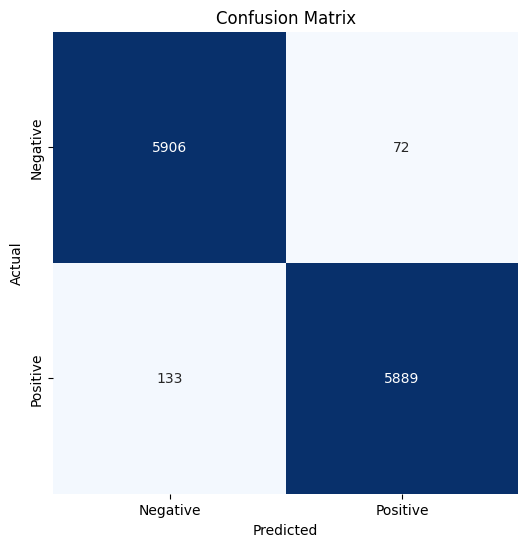

Classification Report:
----------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.98      0.99      0.98      5978
    Positive       0.99      0.98      0.98      6022

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000



In [ ]:
evaluate_model(model, test_dataset)